**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [106]:
# Imports
import numpy as np
from types import SimpleNamespace
from scipy import optimize
import matplotlib.pyplot as plt

# Presets for figures
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [107]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

We create a class for the economy and load an instance of said class.

In [108]:
# Import production economy class from python file
from exam_2024 import production_economy

# Create instance of production economy
model = production_economy(par)

Inside the class we have defined a solver for the consumer's optimization problem, optimizing labour supply for given values of (p1, p2, T, tau). We define a function that calls said solver for arbitrary values of (p1, p2) and T, tau = 0, stores the results and checks the market clearing conditions. For every combination of p1 and p2, we then call this function and store the (p1, p2) where the market clears.

In [109]:
# Function checking if the market clearing conditions hold
def clear_check(model,p1,p2):
    
    #firms
    l1,y1 = model.opt_firm(p1)
    l2,y2 = model.opt_firm(p2)

    #consumers
    l = model.opt_ls(p1,p2, par.T, par.tau)
    c1, c2 = model.opt_cb(l, p1, p2, par.T, par.tau)

    return l == l1+l2 and c1 == y1 and c2 == y2 

# Empty list to store results
clearing = []

# Loop over every combination of p1 and p2
for p1 in np.linspace(0.1,2.0,10):
    for p2 in np.linspace (0.1,2.0,10):
        check = clear_check(model, p1, p2)
        if check == True:
            clearing.append((p1,p2))

print(clearing)

[]


As we can see the loop returns an empty list, meaning that no combination of p1 and p2 clears the market.

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

Inside the class we define a solver for the equilibirum finding the values of (p1, p2, T) for a given values of tau. It does this by solving an equation system of 3 equations: 2 market clearing conditions and the government's balanced budget constraint. Here it uses the optimal labour supply found by the solver for the consumer's optimization problem as input.

we call this solver on our instance of the economy for tau = 0. 

In [110]:
EQ_prices = model.EQ(par.tau)

print(f'The equilibirum prices when tau = 0 are: (p1, p2) = ({EQ_prices[0]:.3f},{EQ_prices[1]:.3f})')

The equilibirum prices when tau = 0 are: (p1, p2) = (2.407,5.616)


Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

We create a solver for the maximum SWF, finding the value of tau. Here it uses the equilibirum prices and the optimal labour supply found from the previous solvers as input.

In [111]:
# Objective function
def SWF_objective(tau):
    p1, p2, T = model.EQ(tau)
    l = model.opt_ls(p1, p2, T, tau)
    c1, c2 = model.opt_cb(l, p1, p2, T, tau)
    y2 = model.opt_firm(p2)[1]
        
    u = np.log(c1**par.alpha * c2**(1-par.alpha)) - par.nu*l**(1+par.epsilon)/(1+par.epsilon)
    SWF = u-par.kappa*y2
    return -SWF

# Call solver
x0 = 0.1
sol_tau = optimize.minimize(SWF_objective, x0 ,method='SLSQP')

/Users/mariathoisenlarsen/Desktop/Programming content /projects-2024-maria/examproject/exam_2024.py:37: RuntimeWarning: invalid value encountered in power
  # Objective function for consumer problem


In [113]:
# Unpack solution
tau = sol_tau.x[0]
p1, p2, T = model.EQ(tau)

print(f'The government should choose tau = {tau:.3f} and T = {T:.3f}')

The government should choose tau = 0.002 and T = 0.006


## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [90]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


We draw the noise term K times for each career and calculate the realized utility for each of those draws. Then we sum accros all the draws for each career to find the average realized utility. Since K is large, we expect the average realised utility to be close to the expected utility. 

In [91]:
# Draw noise terms for each career
np.random.seed(6969)
eps_draws = np.random.normal(loc=0,scale=par.sigma,size=(par.K,par.J))

# Average utility
avg_u = par.v+1/par.K*sum(eps_draws)
print(f'The average realized utility for each career is: u1: {avg_u[0]:.3f}, u2: {avg_u[1]:.3f} and u3 {avg_u[2]:.3f}')

The average realized utility for each career is: u1: 1.000, u2: 2.004 and u3 2.972


This is very close to the expected utility of each career: $\mathbb{E}\left[ u_1 \right] = 1$, $\mathbb{E}\left[ u_2 \right] = 2$ and $\mathbb{E}\left[ u_3 \right] = 3$.

Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

We start by initialising zero-arrays to store the results following the procedure laid out by point 1-3 above. To find the shares, we sum over the elements where the chosen career is 1,2 and 3 respectively to find the total number. Similarily, to find the averages we sum over the elements for every type i.

In [92]:
# Initialize arrays
prior_u = np.zeros((par.N,par.J, par.K))
realized_u = np.zeros((par.N, par.J,par.K))

chosen_career = np.zeros((par.N,par.K))
prior_u_chosen_career = np.zeros((par.N,par.K))
realized_u_chosen_career = np.zeros((par.N,par.K))

# Loop over different graduate types K times
for k in range(1,par.K+1):
    for i in range(1,par.N+1):
        
        # Draw friends noise term and calculate prior expected utility
        friend_draws = np.random.normal(loc=0,scale=par.sigma,size=(i,par.J))
        prior_u[i-1,:,k-1] = par.v+1/i*np.sum(friend_draws, axis=0)
        
        # Draw graduate's own noise term and culculate realized utility
        realized_u[i-1,:,k-1] = par.v+np.random.normal(loc=0,scale=par.sigma,size=(1,par.J))

        # Find chosen career and corresponding prior expected utility and realized utility
        chosen_career[i-1,k-1] = np.argmax(prior_u[i-1,:,k-1])+1
        prior_u_chosen_career[i-1,k-1] = prior_u[i-1,int(chosen_career[i-1,k-1]-1),k-1]
        realized_u_chosen_career[i-1,k-1] = realized_u[i-1,int(chosen_career[i-1,k-1]-1),k-1]

In [86]:
# Initialise array for shares
job_share = np.zeros((par.N,par.J))

# Calculate shares
for i in range(1,par.N+1):
    job_share[i-1,0] = sum(chosen_career[i-1,:]==1)
    job_share[i-1,1] = sum(chosen_career[i-1,:]==2)
    job_share[i-1,2] = sum(chosen_career[i-1,:]==3)

job_share *= 1/par.K

# Prior expected utility of chosen career
prior_chosen_avg = 1/par.K*np.sum(prior_u_chosen_career, axis=1)
realized_chosen_avg = 1/par.K*np.sum(realized_u_chosen_career, axis=1)

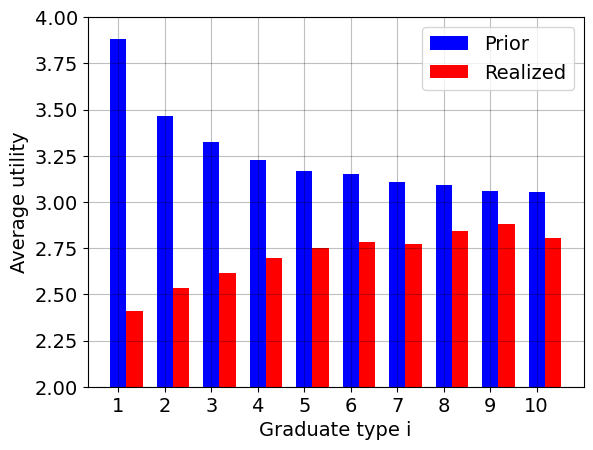

In [87]:
## this code bit was written with help from https://chatgpt.com/

# Set the positions and width for bars
index = np.arange(10) + 1
bar_width = 0.35

# Create the figure and axes
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Plot the bars
bar1 = ax.bar(index, prior_chosen_avg, bar_width, label='Prior', color='blue')
bar2 = ax.bar(index + bar_width, realized_chosen_avg, bar_width,  label='Realized', color='red')

ax.set_ylim(2.0,4);
ax.set_xlabel('Graduate type i')
ax.set_ylabel('Average utility')
ax.set_xticks(index)
ax.legend()

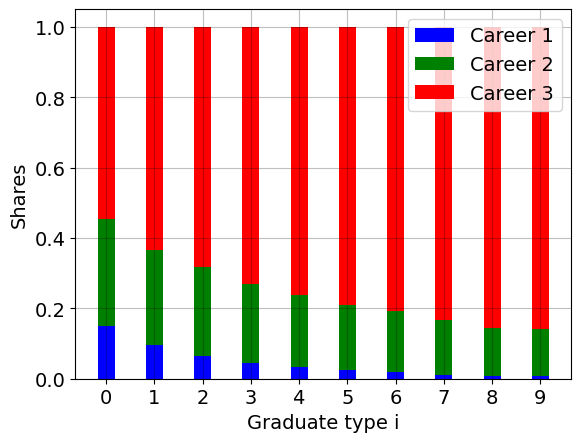

In [88]:
## this code bit was written with help from https://chatgpt.com/
# Number of groups
n_groups = 10

# Set the positions for the bars
index = np.arange(n_groups)
bar_width = 0.35

# Create the figure and axes
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot the bars
bar1 = ax.bar(index, job_share[:,0], bar_width, label='Career 1', color='blue')
bar2 = ax.bar(index, job_share [:,1], bar_width, bottom=job_share[:,0], label='Career 2', color='green')
bar3 = ax.bar(index, job_share[:,2], bar_width, bottom=job_share[:,0] + job_share[:,1], label='Career 3', color='red')

# Add labels, title, and legend
ax.set_xlabel('Graduate type i')
ax.set_ylabel('Shares')
ax.set_xticks(index)
ax.legend()


From this we can see that when the graduate get more friends in each career, they increasingly choose career 3 and their expected utiltity will approximate their realized utility. This is what we would expect from the law of large numbers.

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

In [93]:
# Add switching cost
c = 1
prior_u_switch = prior_u - c

# Initialise arrays
chosen_career_switch = np.zeros((par.N,par.K))
prior_u_chosen_career_switch = np.zeros((par.N,par.K))
realized_u_chosen_career_switch = np.zeros((par.N,par.K))
switch_share = np.zeros((par.N, par.J))

for k in range(1,par.K+1):
    for i in range(1,par.N+1):
       # Update prior to relized utility for the chosen job only
       prior_u_switch[i-1,int(chosen_career[i-1,k-1]-1),k-1] = realized_u_chosen_career[i-1,k-1]

       # Find the chosen career
       chosen_career_switch[i-1,k-1] = np.argmax(prior_u_switch[i-1,:,k-1])+1
       prior_u_chosen_career_switch[i-1,k-1] = prior_u[i-1,int(chosen_career_switch[i-1,k-1]-1),k-1]
       realized_u_chosen_career_switch[i-1,k-1] = realized_u[i-1,int(chosen_career_switch[i-1,k-1]-1),k-1]

In [95]:
# Compute average utility
prior_chosen_avg_switch = 1/par.K*np.sum(prior_u_chosen_career_switch, axis=1)
realized_chosen_avg_switch = 1/par.K*np.sum(realized_u_chosen_career_switch, axis=1)

# Find when switches occur
switch = np.zeros((par.N, par.J))
for i in range(1,par.N+1):
    changes = chosen_career[i-1,chosen_career_switch[i-1,:] != chosen_career[i-1,:]]
    switch[i-1,:] = np.array([sum(changes==1), sum(changes==2), sum(changes==3)])

# Normalize with graduates who choose a given career   
switch = switch/(job_share*par.K)

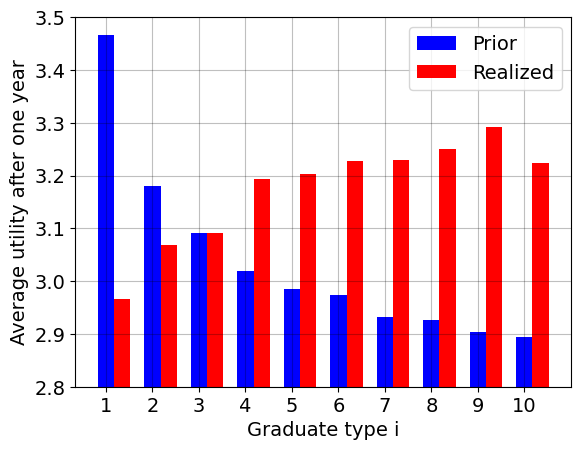

In [96]:
## this code bit was written with help from https://chatgpt.com/

# Set the positions and width for the bars
index = np.arange(10) + 1
bar_width = 0.35

# Create the figure and axes
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# Plot the bars
bar1 = ax.bar(index, prior_chosen_avg_switch, bar_width, label='Prior', color='blue')
bar2 = ax.bar(index + bar_width, realized_chosen_avg_switch, bar_width,  label='Realized', color='red')

ax.set_ylim(2.8,3.5);
ax.set_xlabel('Graduate type i')
ax.set_ylabel('Average utility after one year')
ax.set_xticks(index)
ax.legend()

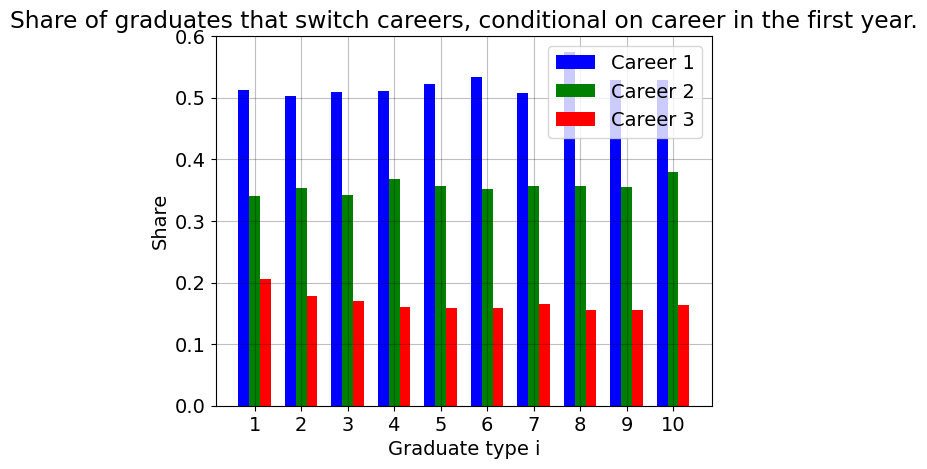

In [97]:
## this code bit was written with help from https://chatgpt.com/
# number of groups
n_groups = 10

# set the positions for the bars
index = np.arange(n_groups) * 1.5
bar_width = 0.35

# Create the figure and axes
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot the bars
bar1 = ax.bar(index, switch[:,0], bar_width, label='Career 1', color='blue')
bar2 = ax.bar(index + bar_width, switch[:,1], bar_width, label='Career 2', color='green')
bar3 = ax.bar(index + 2*bar_width, switch[:,2], bar_width, label='Career 3', color='red')

# Add labels, title, and legend
ax.set_ylim(0,0.6);
ax.set_xlabel('Graduate type i')
ax.set_ylabel('Share')
ax.set_title('Share of graduates that switch careers, conditional on career in the first year.')
ax.set_xticks(index + bar_width)
ax.set_xticklabels([str(i + 1) for i in range(n_groups)])
ax.legend()

From this we see, that after one year in their chosen career, graduates who chose career 1 initially are most likely to swicth followed by those who chose career 2 and lastly those who chose career 3. This seems plausible as career 1 has the lowest expected utility when we know vi followed by career 2. We can also see, that as the graduate gets more friends in each career, their realized utility increases above their expected utility. This is due to the prior expected utility now being influenced by the graduates own subjective experiences.

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [99]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))

**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

We define a function that finds point A, B, C, and D based on the set of random points (x in X) and y using the equations in building block II and call it with the given values of X and y.

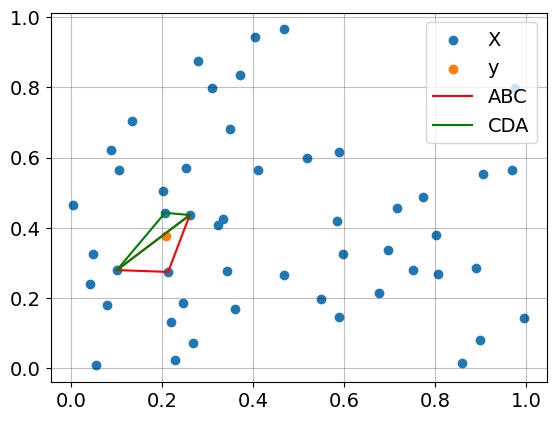

In [100]:
# Function that finds ABCD based on x in X and y coordinates
def get_ABCD(X, Y):

    # Initialise values to hold minimum value for point A, B, C and D
    A_dist = np.inf
    B_dist = np.inf
    C_dist = np.inf
    D_dist = np.inf

    # Initialise arrays for A, B, C and D
    A = np.array([np.nan,np.nan])
    B = np.array([np.nan,np.nan])
    C = np.array([np.nan,np.nan])
    D = np.array([np.nan,np.nan])

    # Find minimum value in X
    for x in X:
        temp = np.sqrt( np.power(x[0]-Y[0],2) + np.power(x[1]-Y[1],2) )
        if (x[0]>Y[0] and x[1]>Y[1]):
            if(temp < A_dist):
                A_dist = temp
                A = np.array([x[0],x[1]])
        elif (x[0]>Y[0] and x[1]<Y[1]):
            if(temp < B_dist):
                B_dist = temp
                B = np.array([x[0],x[1]])
        elif (x[0]<Y[0] and x[1]<Y[1]):
            if(temp < C_dist):
                C_dist = temp
                C = np.array([x[0],x[1]])
        elif (x[0]<Y[0] and x[1]>Y[1]):
            if(temp < D_dist):
                D_dist = temp
                D = np.array([x[0],x[1]])

    return [A,B,C,D]

# Function that plots the two triangles
def plot_Triangle(ax, A, B, C, colors, labels):
    ax.plot([A[0],B[0]],[A[1],B[1]], color=colors, label=labels)
    ax.plot([B[0],C[0]],[B[1],C[1]], color=colors)
    ax.plot([C[0],A[0]],[C[1],A[1]], color=colors)
    return

# Call function to find A, B, C and D
A,B,C,D = get_ABCD(X, y)

## Plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# X and y
ax.scatter(X[:,0],X[:,1], label='X')
ax.scatter(y[0],y[1], label='y')

# Triangle ABC
plot_Triangle(ax, A,B,C,"red", 'ABC')

# Triangle CDA
plot_Triangle(ax, C,D,A,"green", 'CDA')
ax.legend()

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

We create 2 functions from the equations in building block I: one calculating the barycentric coordinates, the other checking wheter the point is inside the triangle. We then call the functions on triangle ABC and CDA from question 1.

In [101]:
# Function that computes barycentric coordinate
def barycentric_coor(A,B,C, y):

    r1_num = (B[1]-C[1])*(y[0]-C[0])+(C[0]-B[0])*(y[1]-C[1])
    r1_denum = (B[1]-C[1])*(A[0]-C[0])+(C[0]-B[0])*(A[1]-C[1])
    r1 = r1_num/r1_denum

    r2_num = (C[1]-A[1])*(y[0]-C[0])+(A[0]-C[0])*(y[1]-C[1])
    r2_denum = r1_denum
    r2 = r2_num/r2_denum

    r3 = 1-r1-r2

    return [r1,r2,r3]

# Check if inside triangle
def inside_triangle(r):
    if(r[0]<=1 and r[0]>=0 and r[1]<=1 and r[1]>=0 and r[2]<=1 and r[2]>=0):
        return True
    else:
        return False

# Compute coordinates
r_ABC = barycentric_coor(A,B,C,y)
r_CDA = barycentric_coor(C,D,A,y)

# Check if inside and print
print("y is inside ABC: " + str(inside_triangle(r_ABC)))
print("y is inside CDA: " + str(inside_triangle(r_CDA)))

y is inside ABC: True
y is inside CDA: False


From this we can see that y is inside triangle ABC, which fits with the illustration above.

Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [102]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

We create a function that performs the algoritm using the prior defined functions.

In [103]:
# Function that performs algorithm
def barycentric_inter(X, y, f):

    # Compute triangles
    A,B,C,D = get_ABCD(X, y)

    # Find coordinates
    r_ABC = barycentric_coor(A,B,C,y)
    r_CDA = barycentric_coor(C,D,A,y)  

    # Return function value if y is in triangle
    if(inside_triangle(r_ABC)):
        return r_ABC[0]*f(A)+r_ABC[1]*f(B)+r_ABC[2]*f(C)
    elif(inside_triangle(r_CDA)):
        return r_CDA[0]*f(C)+r_CDA[1]*f(D)+r_CDA[2]*f(A)

    return np.nan 

# Run algorithm for given X, y and f
func_estimate = barycentric_inter(X,y,f)
print(f"Function gives: {f(y):.3f} and estimate is: {func_estimate:.3f}")

Function gives: 0.079 and estimate is: 0.084


**Question 4:** Repeat question 3 for all points in the set $Y$.

In [104]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [105]:
# We loop over Y
for y in Y:
    func_estimate = barycentric_inter(X,y,f)
    print(f"Function gives: {f(y):.3f} and estimate is: {func_estimate:.3f}")

Function gives: 0.040 and estimate is: 0.040
Function gives: 0.160 and estimate is: 0.159
Function gives: 0.640 and estimate is: nan
Function gives: 0.160 and estimate is: 0.159
Function gives: 0.250 and estimate is: 0.251


The third point in Y returns nan, since it is not surrounded by four x in X, that constitute a square enclosing y.